In [181]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import xarray as xr
from tools.tools import save2nc

import seaborn as sns
sns.set_theme(style="whitegrid")  # 推荐

def create_mask(years, base_path,env_category,env_name, chunks="auto"):
    masks = []
    for y in years:
        data_tmpl = f"{base_path}/{env_category}/{y}/xr_total_{env_category}_{y}.nc"
        data_xr  = xr.open_dataarray(data_tmpl.format(year=y), chunks=chunks)
        cost_tml = f"{base_path}/{env_category}/{y}/xr_{env_name}_{y}.nc"
        cost_xr = xr.open_dataarray(cost_tml.format(year=y), chunks=chunks)
        m = (data_xr >= 1) & (cost_xr >= 1)
        masks.append(m.expand_dims(year=[y]))
    mask = xr.concat(masks, dim="year")
    mask.name = "mask"
    mask.attrs["description"] = "True if both env and cost >= 1, else False"
    return mask

In [182]:
def create_xarray(years, base_path, env_category, env_name,mask=None,
                  engine="h5netcdf",
                  cell_dim="cell", cell_chunk="auto",
                  year_chunk=1, parallel=False):
    """
    以 year 维度拼接多个年度 NetCDF，懒加载+分块，避免过多文件句柄。
    """
    file_paths = [
        os.path.join(base_path, str(env_category), str(y), f"xr_{env_name}_{y}.nc")
        for y in years
    ]
    missing = [p for p in file_paths if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(f"以下文件未找到:\n" + "\n".join(missing))

    # 从文件名提取实际年份，确保坐标与文件顺序一致
    valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in file_paths]

    ds = xr.open_mfdataset(
        file_paths,
        engine=engine,
        combine="nested",          # 明确“按给定顺序拼接”
        concat_dim="year",         # 新增 year 维度
        parallel=parallel,         # 一般 False 更稳，避免句柄并发
        chunks={cell_dim: cell_chunk, "year": year_chunk}  # year=1，cell 分块
    ).assign_coords(year=valid_years)
    
    if mask is not None:
        ds = ds.where(mask, other=0)  # 使用掩码，非掩码区域设为 0

    return ds

def sum_except_year(obj: xr.Dataset | xr.DataArray) -> xr.Dataset | xr.DataArray:
    """
    对 xarray 对象在除 'year' 以外的所有维度上求和。
    支持 DataArray 和 Dataset。
    """
    if isinstance(obj, xr.DataArray):
        return obj.sum(dim=set(obj.dims) - {"year"})
    elif isinstance(obj, xr.Dataset):
        return obj.map(lambda v: v.sum(dim=set(v.dims) - {"year"}))
    else:
        raise TypeError("输入必须是 xarray.DataArray 或 xarray.Dataset")

In [183]:
import os
import xarray as xr
from joblib import Parallel, delayed


def process_file(file_path, year_idx, cat, mask_year=None):
    """
    处理单个文件：加载 -> (可选)按当年mask筛选 -> 对所有非year维求和 -> 返回 year 维标量
    """
    print(f"Processing {file_path}")
    ds_one = xr.open_dataset(file_path, chunks="auto")
    main_var = next(iter(ds_one.data_vars))
    da = ds_one[main_var]

    # 如果给了当年的 mask，先对齐再筛选
    if mask_year is not None:
        # 对齐到共同维度（一般是 cell）
        da, mask_year = xr.align(da, mask_year, join="inner")
        da = da.where(mask_year)

    # 对除 "year" 以外的所有维求和成一个标量
    reduce_dims = [d for d in da.dims if d != "year"]
    s = da.sum(dim=reduce_dims)

    # 保证是标量（如果还带着year坐标，取该年的值）
    if "year" in s.dims:
        s = s.sel(year=year_idx)

    return xr.Dataset({cat: xr.DataArray([s], dims=["year"], coords={"year": [year_idx]})})


def create_cost_year_series(
    years,
    base_path,
    env_category,
    mask=None,                 # <- 新增：可选的 (year, cell) 布尔mask
    year_chunk=-1,
    parallel=True,
    cost_categories=("cost_ag",
                     "cost_agricultural_management",
                     "cost_non_ag",
                     "cost_transition_ag2ag_diff",
                     "transition_cost_ag2non_ag_amortised_diff"),
    finalize="compute",        # "lazy" | "persist" | "compute"
):
    """
    对每个 cost_category:
      - 逐文件打开，(可选)应用 mask(year, cell)
      - 将所有非year维求和成标量
      - 拼出 1D 年序列
    合并所有 cost_category，并追加 TOTAL。
    返回：
      da_year: DataArray, 维度 (cost_category, year)，含 'TOTAL'
    """

    # 如果提供了 mask，限定有效年份为交集（避免 mask 没有的年份报错）
    years = list(years)
    if mask is not None:
        mask_years = set(mask.coords["year"].values.tolist())
        years_in_both = [y for y in years if y in mask_years]
        if not years_in_both:
            raise ValueError("提供的 mask 不包含任何所需年份。")
        if len(years_in_both) != len(years):
            missing = sorted(set(years) - set(years_in_both))
            print(f"[WARN] 这些年份不在mask中，将跳过：{missing}")
        years = years_in_both

    per_cat_ds = []

    for cat in cost_categories:
        # 生成文件路径
        paths = [os.path.join(base_path, str(env_category), str(y),
                              f"xr_{cat}_{env_category}_{y}.nc")
                 for y in years]
        exist = [p for p in paths if os.path.exists(p)]
        if not exist:
            raise FileNotFoundError(f"未找到 {cat} 的 NetCDF 文件。")

        # 文件对应的年份
        valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in exist]

        # 为并行准备每年的当年mask切片（若有）
        mask_slices = None
        if mask is not None:
            # 确保 mask 是按年可索引的
            mask_slices = {y: mask.sel(year=y) for y in valid_years}

        # 并行或串行处理
        if parallel:
            ds_list = Parallel(n_jobs=-1, backend="loky")(
                delayed(process_file)(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            )
        else:
            ds_list = [
                process_file(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            ]

        # 沿 year 维拼接
        ds_cat = xr.concat(ds_list, dim="year").assign_coords(year=valid_years)
        if year_chunk > 0 and finalize != "compute":
            ds_cat = ds_cat.chunk({"year": year_chunk})
        per_cat_ds.append(ds_cat)

    # 合并所有 cost_category -> (cost_category, year)
    ds_year = xr.merge(per_cat_ds, compat="override", join="exact")
    da_year = ds_year.to_array(dim="cost_category").transpose("cost_category", "year")

    # 追加 TOTAL
    da_total = da_year.sum(dim="cost_category", skipna=True).expand_dims(cost_category=["TOTAL"])
    da_year = xr.concat([da_year, da_total], dim="cost_category")

    # 计算策略
    if finalize == "compute":
        return da_year.compute()
    if finalize == "persist":
        return da_year.persist()
    return da_year

def quick_plot(da, title, figure_path):
    fig, ax = plt.subplots(figsize=(5, 4))

    # 添加 marker 参数创建点线图
    da.plot(ax=ax, marker='o', linestyle='-', markersize=4)
    ax.set(ylabel='', title=title,xlabel='')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, title+".png"))
    plt.show()

In [184]:
task_name = '20250831_Price_Task_NCI'
base_path = f"../../../output/{task_name}/carbon_price/0_base_data"
excel_path = f"../../../output/{task_name}/carbon_price/1_excel"
figure_path = f"../../../output/{task_name}/carbon_price/2_figure"
os.makedirs(excel_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

env_category = "carbon_100_bio_50"
env_name = f"total_cost_{env_category}_amortised"
years = list(range(2011, 2051))
xr_bio_mask = create_mask(years, base_path,env_category, env_name)

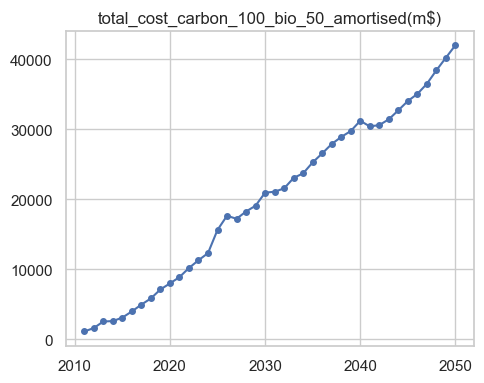

In [185]:
xr_bio_cost_a = create_xarray(years, base_path, env_category, env_name)
da = (xr_bio_cost_a["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m$)', figure_path)

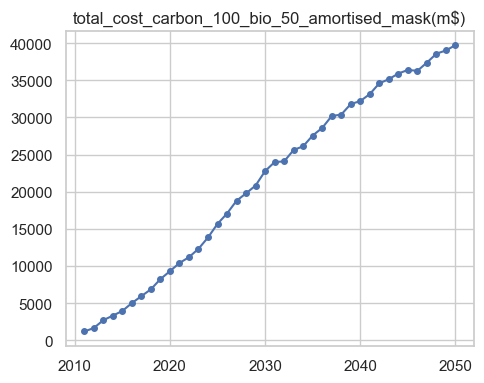

In [186]:
xr_bio_cost_a_m = create_xarray(years, base_path, env_category, env_name, mask=xr_bio_mask)
da = (xr_bio_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask(m$)', figure_path)

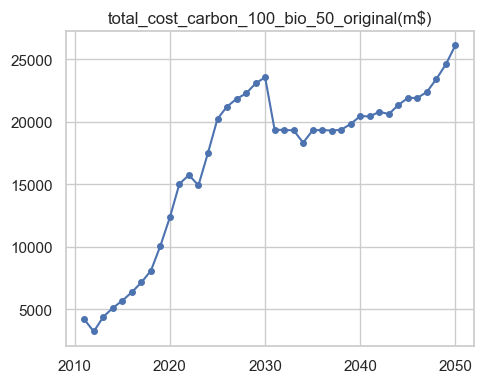

In [187]:
env_name = f"total_cost_{env_category}_original"
xr_bio_cost_o = create_xarray(years, base_path, env_category, env_name)
da = (xr_bio_cost_o["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m$)', figure_path)

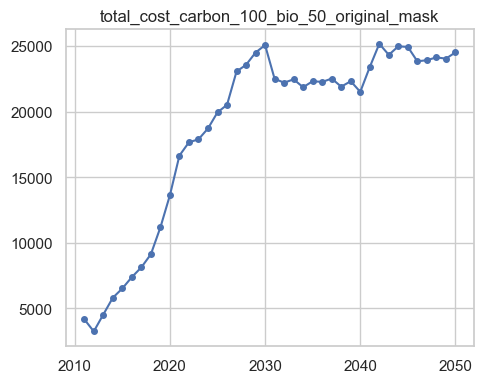

In [188]:
env_name = f"total_cost_{env_category}_original"
xr_bio_cost_o_m = create_xarray(years, base_path, env_category, env_name, mask=xr_bio_mask)
da = (xr_bio_cost_o_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

In [189]:
env_category = "carbon_100_bio_50"
xr_bio_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_bio_cost_series, os.path.join(base_path, 'Results', "xr_bio_cost_series.nc"))
df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_bio_cost

env_category = "carbon_80_bio_40"
xr_bio_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_bio_cost_series, os.path.join(base_path, 'Results', "xr_bio_cost_series.nc"))
df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_bio_cost

env_category = "carbon_60_bio_30"
xr_bio_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_bio_cost_series, os.path.join(base_path, 'Results', "xr_bio_cost_series.nc"))
df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_bio_cost

env_category = "carbon_40_bio_20"
xr_bio_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_bio_cost_series, os.path.join(base_path, 'Results', "xr_bio_cost_series.nc"))
df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_bio_cost

env_category = "carbon_20_bio_10"
xr_bio_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_bio_cost_series, os.path.join(base_path, 'Results', "xr_bio_cost_series.nc"))
df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_bio_cost

cost_category,cost_ag,cost_agricultural_management,cost_non_ag,cost_transition_ag2ag_diff,transition_cost_ag2non_ag_amortised_diff,TOTAL
year,,,,,,
2011,-0.000012,-0.002098,0.000280,-0.025514,0.000928,-0.026417
2012,0.023252,-0.297051,0.003728,1.466856,0.009337,1.206122
2013,40.014214,-134.964859,33.683395,75.913437,13.467735,28.113916
2014,21.111002,-131.620361,98.732796,-112.553154,40.191875,-84.137840
2015,66.310051,-183.714600,159.382141,2.080288,67.858131,111.916016
2016,59.396374,-195.278763,214.017212,64.070282,105.010735,247.215820
2017,120.854080,-307.985596,254.746033,84.416267,141.627289,293.658081
2018,145.141068,-283.925842,315.168335,-15.339400,191.583817,352.627960
2019,108.885452,-255.336334,372.210510,-10.069711,246.937408,462.627319


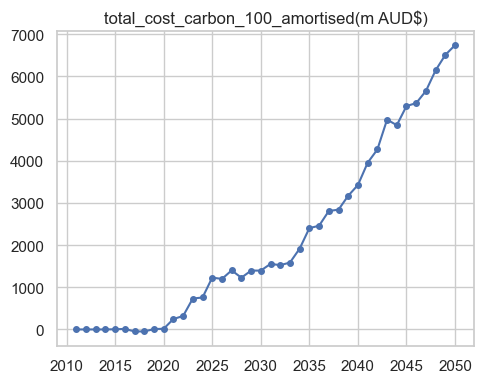

In [190]:
env_category = "carbon_100"
env_name = f"total_cost_{env_category}_amortised"
xr_carbon_mask = create_mask(years, base_path,env_category, env_name)
xr_carbon_cost_a = create_xarray(years, base_path, env_category, env_name)
da= (xr_carbon_cost_a["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m AUD$)', figure_path)

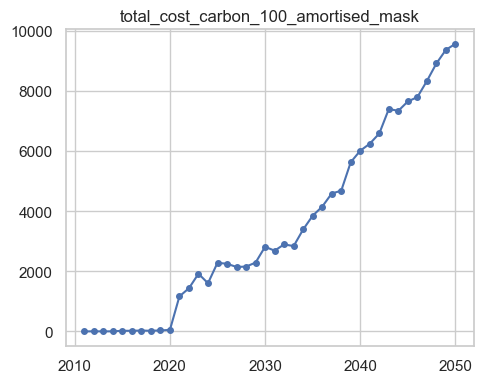

In [191]:
xr_carbon_cost_a_m = create_xarray(years, base_path, env_category, env_name, mask=xr_carbon_mask)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

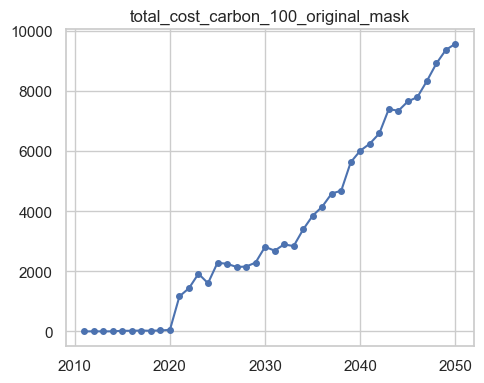

In [192]:
env_name = f"total_cost_{env_category}_original"
xr_carbon_cost_o_m = create_xarray(years, base_path, env_category, env_name, mask=xr_carbon_mask)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

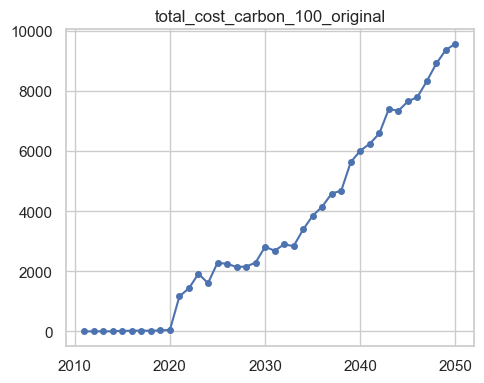

In [193]:
env_name = f"total_cost_{env_category}_original"
xr_carbon_cost_o = create_xarray(years, base_path, env_category, env_name)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}', figure_path)

In [194]:
env_category = "carbon_100"
xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_carbon_cost_series, os.path.join(base_path, 'Results', "xr_carbon_cost_series.nc"))
df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_carbon_cost

env_category = "carbon_80"
xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_carbon_cost_series, os.path.join(base_path, 'Results', "xr_carbon_cost_series.nc"))
df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_carbon_cost

env_category = "carbon_60"
xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_carbon_cost_series, os.path.join(base_path, 'Results', "xr_carbon_cost_series.nc"))
df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_carbon_cost

env_category = "carbon_40"
xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_carbon_cost_series, os.path.join(base_path, 'Results', "xr_carbon_cost_series.nc"))
df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_carbon_cost

env_category = "carbon_20"
xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category)
save2nc(xr_carbon_cost_series, os.path.join(base_path, 'Results', "xr_carbon_cost_series.nc"))
df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
df_carbon_cost

cost_category,cost_ag,cost_agricultural_management,cost_non_ag,cost_transition_ag2ag_diff,transition_cost_ag2non_ag_amortised_diff,TOTAL
year,,,,,,
2011,22.822153,294.219543,52.176975,1020.863586,239.452469,1629.534668
2012,15.243871,289.378998,51.761955,-516.395508,239.908249,79.897568
2013,56.370823,66.633980,52.251663,49.542416,240.564224,465.363098
2014,51.826012,78.610245,52.269451,-2.979388,241.238525,420.964874
2015,78.778114,119.320335,53.612648,-72.244209,242.423569,421.890472
2016,31.338406,283.166412,57.266697,-92.221230,243.711975,523.262268
2017,12.182574,210.902679,55.828381,-55.023132,243.421432,467.311951
2018,14.765310,171.051788,53.050865,11.464225,240.897537,491.229736
2019,63.544155,238.850555,53.552048,-28.013327,241.131104,569.064575


In [195]:
env_category = "carbon_100"
xr_carbon_m = create_xarray(years, base_path, "carbon_100", f"total_{env_category}", mask=xr_carbon_mask)
xr_carbon = create_xarray(years, base_path, "carbon_100", f"total_{env_category}")

In [196]:
xr_carbon_price = xr_carbon_cost_a/xr_carbon*xr_carbon_mask

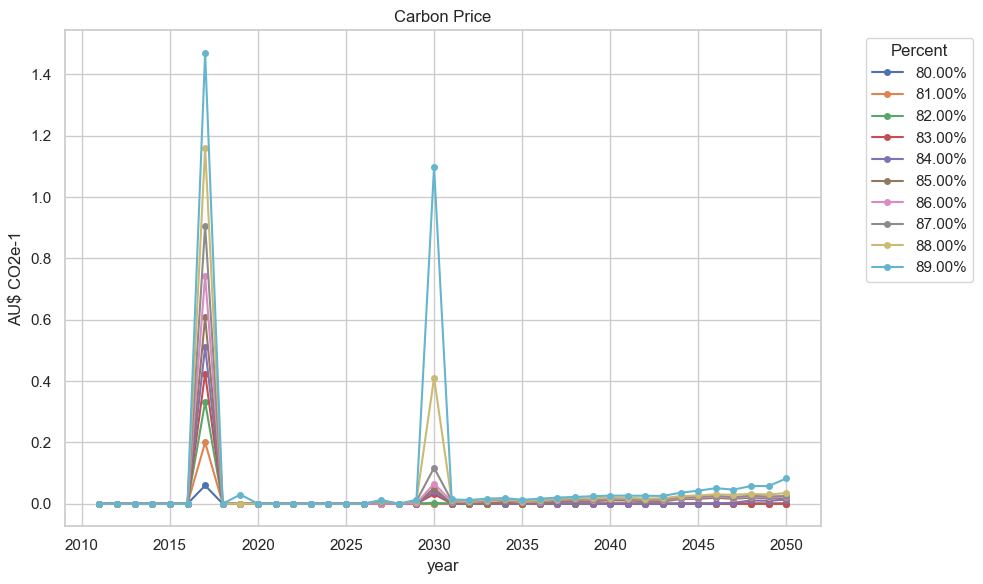

In [197]:
import matplotlib.pyplot as plt
import numpy as np

da = xr_carbon_price["data"]  # (year, cell)

# 1) 计算每年在 cell 维度上的 85%~99% 分位数
qs = da.quantile(q=np.arange(0.80, 0.90, 0.01), dim="cell", skipna=True)  # (quantile, year)

# 2) 画多条分位数曲线
fig, ax = plt.subplots(figsize=(10,6))
qs.T.plot.line(x="year", ax=ax,marker="o",markersize=4, add_legend=False)  # 不要自动图例

# 3) 手动指定图例标签
labels = [f"{q*100:.2f}%" for q in qs.coords["quantile"].values]
ax.legend(labels, title="Percent", bbox_to_anchor=(1.05,1), loc="upper left")

ax.set(ylabel="AU$ CO2e-1",title="Carbon Price")
plt.tight_layout()
plt.show()


In [198]:
save2nc(xr_carbon_price.sel(year=2050), os.path.join(base_path, "carbon_100","2050", "xr_carbon_price_2050.nc"))

In [199]:
da1 = xr_carbon_price.sel(year=2050)['data']
da1 = da1.where(da1>0)

In [200]:
da1.quantile(0.97, dim="cell", skipna=True).values

array(418.08573853)

In [201]:
xr_data = xr.open_dataset(f"{base_path}/{env_category}/2050/xr_carbon_price_2050.nc")
da_result = xr_data['data']# .where(xr_data['data'] > 1)
da_result = da_result.sum(dim=[d for d in da_result.dims if d != "cell"], skipna=True)
da_result.quantile(0.97, dim="cell", skipna=True).item()

102.06822463989258

In [202]:
xr_data['data'].min().values

array(-0., dtype=float32)

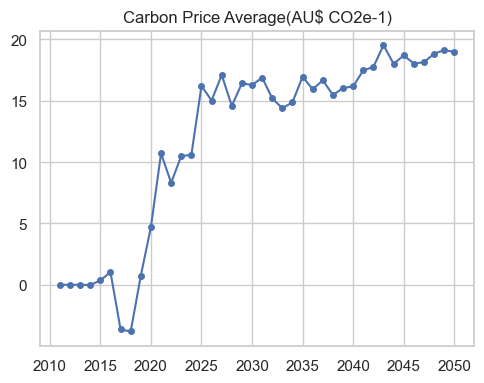

In [203]:
xr_carbon_price_ave = (xr_carbon_cost_a.sum(dim="cell")/xr_carbon.sum(dim="cell"))
da = xr_carbon_price_ave["data"]
quick_plot(da, "Carbon Price Average(AU$ CO2e-1)", figure_path)

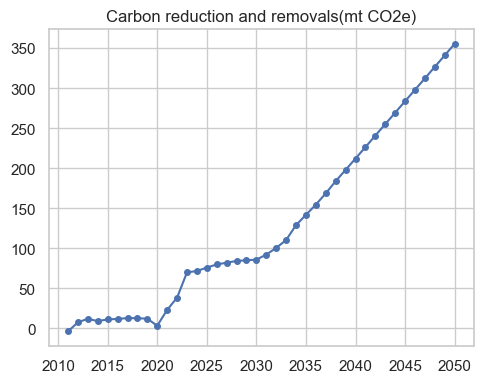

In [204]:
da = xr_carbon.sum(dim='cell')["data"] / 1e6
quick_plot(da, "Carbon reduction and removals(mt CO2e)", figure_path)

In [205]:
xr_bio = create_xarray(years, base_path, "carbon_100_bio_50", f"total_carbon_100_bio_50")
xr_bio_price = xr_bio_cost_a/xr_bio*xr_bio_mask
save2nc(xr_bio_price.sel(year=2050), os.path.join(base_path, "carbon_100_bio_50",'2050', "xr_bio_price_2050.nc"))

In [206]:
da = xr_bio_price.sel(year=2050)['data']
print(da)
print(da.quantile(0.92, dim="cell").values)

<xarray.DataArray 'data' (cell: 168778)> Size: 675kB
dask.array<getitem, shape=(168778,), dtype=float32, chunksize=(168778,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 1MB 0 1 2 3 4 5 ... 168773 168774 168775 168776 168777
    year     int32 4B 2050
735.2600537109377


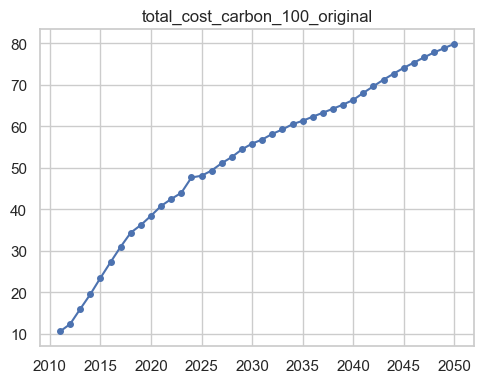

In [207]:
da= (xr_bio["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}', figure_path)

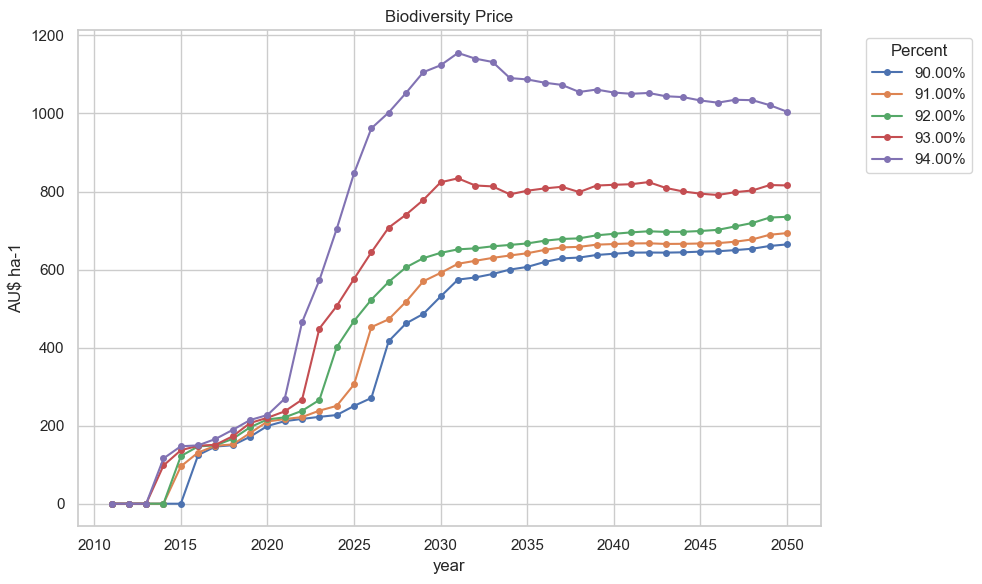

In [208]:
import matplotlib.pyplot as plt
import numpy as np

da = xr_bio_price["data"]  # (year, cell)

# 1) 计算每年在 cell 维度上的 85%~99% 分位数
qs = da.quantile(q=np.arange(0.90, 0.95, 0.01), dim="cell", skipna=True)  # (quantile, year)

# 2) 画多条分位数曲线
fig, ax = plt.subplots(figsize=(10,6))
qs.T.plot.line(x="year", ax=ax,marker="o",markersize=4, add_legend=False)  # 不要自动图例

# 3) 手动指定图例标签
labels = [f"{q*100:.2f}%" for q in qs.coords["quantile"].values]
ax.legend(labels, title="Percent", bbox_to_anchor=(1.05,1), loc="upper left")

ax.set(ylabel="AU$ ha-1",title="Biodiversity Price")
plt.tight_layout()
plt.show()


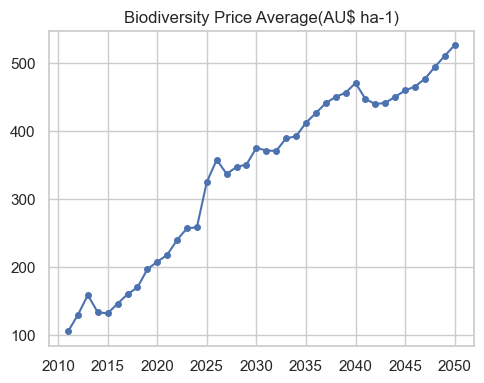

In [209]:
xr_bio_price_ave = (xr_bio_cost_a.sum(dim="cell")/xr_bio.sum(dim="cell"))
da = xr_bio_price_ave["data"]
quick_plot(da, "Biodiversity Price Average(AU$ ha-1)", figure_path)

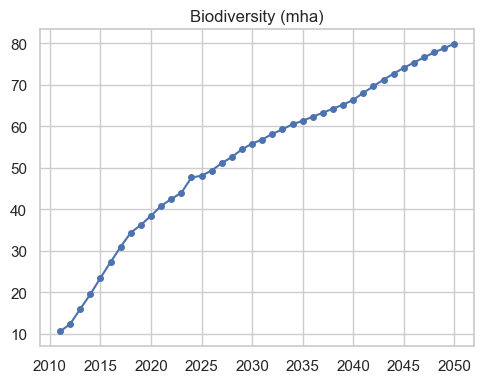

In [210]:
da = xr_bio.sum(dim='cell')["data"] / 1e6
quick_plot(da, "Biodiversity (mha)", figure_path)

In [211]:
def load_sum_series(
    base_path,
    years,
    cost_categories,
    suffix: str = "carbon_100.nc",
    chunks="auto",
    finalize: str = "compute",     # "compute" | "persist" | "lazy"
):
    """
    打开 base_path/<year>/ 下每个 cost_category 对应的 NetCDF，
    对主变量在所有维度上求和，得到逐年的标量序列。

    兼容两种文件名模式（按顺序尝试）：
      1) <base>/<year>/<name>_<year>.nc
      2) <base>/<year>/<name>_<suffix>

    返回：
      ds_year: Dataset，包含每个 cost_category 的 1D 年度序列
      da_year: DataArray，dims=(year, cost_category)
    """

    per_cat_series = {}

    for cat in cost_categories:
        values = []
        valid_years = []
        for y in years:
            # 候选路径（按顺序尝试）
            path = os.path.join(base_path,suffix, str(y), f"{cat}_{suffix}_{y}.nc")
            # print(path)
            ds = xr.open_dataset(path, chunks=chunks)
            da = ds['data']

            # 对所有维度求和成标量
            s = da.sum(dim=list(da.dims))

            # 收集
            values.append(s)
            valid_years.append(y)

        # 把每年的标量拼成 (year) 的 DataArray
        cat_da = xr.concat(values, dim="year")
        cat_da = cat_da.assign_coords(year=np.array(valid_years, dtype=int))
        per_cat_series[cat] = cat_da

    # 合并为 Dataset：每个变量名 = cost_category，dims=(year)
    ds_year = xr.Dataset(per_cat_series)

    # 对齐所有类别的年份交集，保证整齐
    ds_year = ds_year.sortby("year").transpose("year", ...)

    # 可选计算策略
    if finalize == "compute":
        ds_year = ds_year.compute()
    elif finalize == "persist":
        ds_year = ds_year.persist()
    # "lazy" 则保持 dask graph

    # 也给一个 to_array 版本：dims=(cost_category, year)
    da_year = ds_year.to_array("cost_category").transpose("year", "cost_category").rename("data")

    return  da_year


In [212]:
cost_category = ['xr_cost_ag', 'xr_cost_agricultural_management', 'xr_cost_non_ag','xr_cost_transition_ag2ag_diff','xr_transition_cost_ag2non_ag_amortised_diff']
suffix = 'carbon_100'
xr_carbon_cost_category = load_sum_series(base_path,years,cost_category,suffix)

In [213]:
cost_category = ['xr_cost_ag', 'xr_cost_agricultural_management', 'xr_cost_non_ag','xr_cost_transition_ag2ag_diff','xr_transition_cost_ag2non_ag_amortised_diff']
suffix = 'carbon_100_bio_50'
xr_bio_cost_category = load_sum_series(base_path,years,cost_category,suffix)
save2nc(xr_carbon_cost_category,os.path.join(base_path, 'Results', "xr_carbon_cost_category.nc"))
save2nc(xr_bio_cost_category,os.path.join(base_path, 'Results', "xr_bio_cost_category.nc"))

In [214]:
xr_carbon_cost_tn = create_xarray(years, base_path,'carbon_100','transition_cost_ag2non_ag_amortised_diff_carbon_100')
xr_carbon_cost_tn = xr_carbon_cost_tn.sum(dim=['From land-use','cell'])
save2nc(xr_carbon_cost_tn,os.path.join(base_path, 'Results', "xr_carbon_cost_tn.nc"))

In [215]:
xr_carbon_cost_tn = create_xarray(years, base_path,'carbon_100','transition_cost_ag2non_ag_amortised_diff_carbon_100')
xr_carbon_cost_tn = xr_carbon_cost_tn.sum(dim=['From land-use','cell'])
save2nc(xr_carbon_cost_tn,os.path.join(base_path, 'Results', "xr_carbon_cost_tn.nc"))

In [216]:
xr_carbon_cost_tn = create_xarray(years, base_path,'carbon_100_bio_50','transition_cost_ag2non_ag_amortised_diff_carbon_100_bio_50')
xr_carbon_cost_tn = xr_carbon_cost_tn.sum(dim=['From land-use','cell'])
save2nc(xr_carbon_cost_tn,os.path.join(base_path, 'Results', "xr_bio_cost_tn.nc"))

In [217]:
xr_carbon_cost_tn.coords["To land-use"].values

array(['BECCS', 'Beef Agroforestry', 'Beef Carbon Plantings (Belt)',
       'Carbon Plantings (Block)', 'Destocked - natural land',
       'Environmental Plantings', 'Riparian Plantings',
       'Sheep Agroforestry', 'Sheep Carbon Plantings (Belt)'],
      dtype='<U29')

In [218]:
xr_carbon_cost_tn['data'].to_pandas()/1e6

To land-use,BECCS,Beef Agroforestry,Beef Carbon Plantings (Belt),Carbon Plantings (Block),Destocked - natural land,Environmental Plantings,Riparian Plantings,Sheep Agroforestry,Sheep Carbon Plantings (Belt)
year,,,,,,,,,
2011,0.0,0.000049,0.000046,0.000024,243.815323,4.884009,2.742510,-0.145783,0.000041
2012,0.0,0.000298,0.000285,0.000213,393.343964,5.955060,5.257240,-0.145530,0.000283
2013,0.0,0.000689,0.000657,0.000475,566.822266,7.026304,14.888444,-0.145133,0.000662
2014,0.0,0.001234,0.001163,0.000813,787.794189,8.097746,45.605270,-0.144591,0.001176
2015,0.0,0.001856,0.001743,0.001171,1031.904419,9.570684,80.333725,-0.143972,0.001763
2016,0.0,0.002480,0.002329,0.001513,1272.911621,10.862348,124.570702,-0.143357,0.002351
2017,0.0,0.002370,0.002229,0.000923,1506.783081,11.529022,184.047409,-0.143518,0.002215
2018,0.0,0.002314,0.002179,0.000357,1724.529297,12.195807,288.589233,-1.359712,0.002132
2019,0.0,0.002205,0.002082,-0.000279,1877.686523,32.887814,518.553101,1.074817,0.002000
